In [1]:
import scipy.io as sio

In [2]:
import os

In [3]:
mat_contents = sio.loadmat('ImGHIrec2.mat')

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
path=os.getcwd()

In [5]:
DateTimeCom=sio.loadmat('DateTimeCom.mat')
dt=DateTimeCom['DateTimeCom']


In [6]:
import numpy as np




In [7]:
import pandas as pd
dt=pd.to_datetime(dt)

In [8]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cam_Param', 'Coeffp', 'DB_Name', 'DHI', 'DHI_PSI', 'DNI', 'None', 'Day_ID', 'GHI', 'GHI_PSI', 'GPS', 'Gray64bits', 'HDR64bits', 'HDR_log64bits', 'ImGHIrec2', 'ImGreyghi', 'Image_ID', 'MAJ', 'Mask', 'N', 'PAA', 'PSA', 'PZA', 'RGB64bits', 'RSIFile', 'RSITemp', 'SAA', 'SPA', 'SPA_lim', 'SZA', 'Time_zone', 'Vout', 'dataPath', 'files', 'i', 'ind_PSI', 'ind_RSI', 'path_data', 'sqlquery', '__function_workspace__'])

In [9]:
mat_Im=mat_contents["ImGHIrec2"]
mat_Im.shape

(28, 26, 39502)

In [10]:
x=mat_Im[:,:,70]
y=mat_Im[:,:,75]

In [11]:
x=x.reshape(x.size,1)
y=y.reshape(y.size,1)



In [12]:

from matplotlib import pyplot as plt


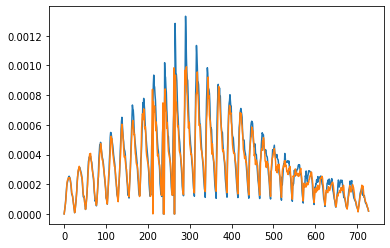

In [563]:
ghi=mat_contents["GHI"]
dni=mat_contents["DNI"]
dhi=mat_contents["DHI"]



ghiset=ghi[:13108]
dniset=dni[:13108]
dhiset=dhi[:13108]



max(ghiset),max(dniset),max(dhiset)

(array([1268.934]), array([922.135]), array([601.1367]))

In [629]:
dataset_orig=mat_Im.reshape(mat_Im.shape[0]*mat_Im.shape[1],mat_Im.shape[2])

dataset_orig=dataset_orig[:,:13108]


#dataset_orig=dataset_orig[:,::4]




from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

ghiset=scaler.fit_transform(ghiset)
dhiset=scaler.fit_transform(dhiset)


#df_test['scaled_GHI'] = scaler.fit_transform(np.array(df_test['GHI']).reshape(-1, 1))

train_size=int(dataset_orig.shape[1]*.85)

data_train=dataset[:,:train_size]
data_test=dataset[:,train_size:]
data_train=data_train.T
data_test=data_test.T
ghiset_train=np.c_[ghiset[:train_size], dhiset[:train_size]]
ghiset_test=np.c_[ghiset[train_size:] ,dhiset[train_size:]]



In [630]:
ghiset.shape

(13108, 1)

In [631]:
data_train.shape,data_test.shape,dataset_orig.shape,ghiset_train.shape
#train_size

((11141, 728), (1967, 728), (728, 13108), (11141, 2))

In [632]:
dimInput=1
X_train, y_train = data_train,ghiset_train
X_val, y_val = data_test,ghiset_test

In [633]:
X_val.shape,y_val.shape,X_train.shape,y_train.shape


((1967, 728), (1967, 2), (11141, 728), (11141, 2))

In [634]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [635]:
#definition des entrées. None indicates the number of instances
input_layer = Input(shape=(728,), dtype='float32')

In [636]:
#Les couches Denses avec une fonction d'activation relu
dense1 = Dense(128, activation='sigmoid')(input_layer)
dropout_layer = Dropout(0.1)(dense1)


dense2 = Dense(128, activation='sigmoid')(dense1)
dropout_layer = Dropout(0.1)(dense2)


#
dense3 = Dense(64, activation='sigmoid')(dense2)
dropout_layer = Dropout(0.1)(dense3)




In [637]:
output_layer = Dense(2, activation='sigmoid')(dropout_layer)


In [638]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')

ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 728)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 128)               93312     
_________________________________________________________________
dense_166 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_167 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_121 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 2)                 130       
Total params: 118,210
Trainable params: 118,210
Non-trainable params: 0
_________________________________________________________________


In [639]:
save_weights_at = os.path.join(path, 'CamGHI_MLP_poids.{epoch:02d}-{val_loss:.4f}.hdf5')
print(save_weights_at)

/Users/hanany/Documents/SkyImageGlobalHorizontalIrradiation/CamGHI_MLP_poids.{epoch:02d}-{val_loss:.4f}.hdf5


In [640]:
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)


In [642]:
ts_model.fit(x=X_train, y=y_train, batch_size=100, epochs=100,verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
           shuffle=True)


Train on 11141 samples, validate on 1967 samples
Epoch 1/100
11141/11141 [==============================] - 4s 335us/step - loss: 0.0148 - val_loss: 0.0114
Epoch 2/100
11141/11141 [==============================] - 4s 324us/step - loss: 0.0135 - val_loss: 0.0077
Epoch 3/100
11141/11141 [==============================] - 4s 344us/step - loss: 0.0122 - val_loss: 0.0073
Epoch 4/100
11141/11141 [==============================] - 4s 351us/step - loss: 0.0107 - val_loss: 0.0051
Epoch 5/100
11141/11141 [==============================] - 4s 347us/step - loss: 0.0090 - val_loss: 0.0052
Epoch 6/100
11141/11141 [==============================] - 4s 335us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 7/100
11141/11141 [==============================] - 4s 354us/step - loss: 0.0068 - val_loss: 0.0021
Epoch 8/100
11141/11141 [==============================] - 4s 350us/step - loss: 0.0063 - val_loss: 0.0024
Epoch 9/100
11141/11141 [==============================] - 4s 334us/step - loss: 0.0059 - val_l

11141/11141 [==============================] - 5s 449us/step - loss: 0.0013 - val_loss: 8.5994e-04
Epoch 76/100
11141/11141 [==============================] - 5s 416us/step - loss: 0.0013 - val_loss: 7.6243e-04
Epoch 77/100
11141/11141 [==============================] - 5s 427us/step - loss: 0.0012 - val_loss: 7.9441e-04
Epoch 78/100
11141/11141 [==============================] - 5s 427us/step - loss: 0.0012 - val_loss: 7.3580e-04
Epoch 79/100
11141/11141 [==============================] - 5s 426us/step - loss: 0.0012 - val_loss: 7.2964e-04
Epoch 80/100
11141/11141 [==============================] - 5s 430us/step - loss: 0.0012 - val_loss: 7.9934e-04
Epoch 81/100
11141/11141 [==============================] - 5s 425us/step - loss: 0.0012 - val_loss: 7.3747e-04
Epoch 82/100
11141/11141 [==============================] - 5s 428us/step - loss: 0.0011 - val_loss: 8.5690e-04
Epoch 83/100
11141/11141 [==============================] - 5s 416us/step - loss: 0.0011 - val_loss: 6.8125e-04
Epoch

In [644]:
files = sorted(os.listdir(path), key=os.path.getctime)

oldest = files[0]
newest = files[-2]
print(newest)

CamGHI_MLP_poids.91-0.0007.hdf5


In [645]:
os.path.join(path,newest)

'/Users/hanany/Documents/SkyImageGlobalHorizontalIrradiation/CamGHI_MLP_poids.91-0.0007.hdf5'

In [646]:
best_model = load_model(os.path.join(path,newest))
preds = best_model.predict(X_val)
pred_PRES = preds
pred_PRES = np.squeeze(pred_PRES)


from sklearn.metrics import r2_score,mean_squared_error
r2 = r2_score(y_val, pred_PRES)

#print('R-squared for the validation set:'.format(r2))
print("R-squared en test  est {} ".format(r2))

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(y_val, pred_PRES))
print("L'erreur en test  est {} (nRMSE)".format(testScore))



R-squared en test  est 0.8981306431129993 
L'erreur en test  est 0.025860836595737523 (nRMSE)


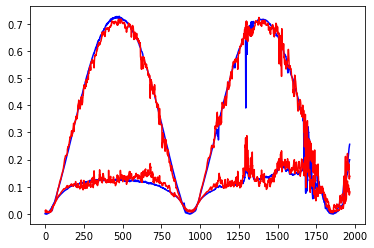

In [648]:
ghi_est=pred_PRES

ghi_true=y_val

plt.plot(ghi_true,'b')
plt.plot(ghi_est,'r')



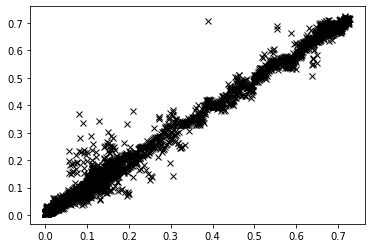

In [649]:
plt.plot(ghi_true,ghi_est,'kx')



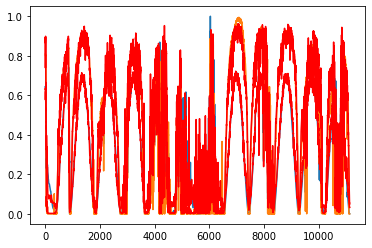

In [604]:
fits = best_model.predict(X_train)

plt.plot(y_train)
plt.plot(fits,'r')
plt.show()


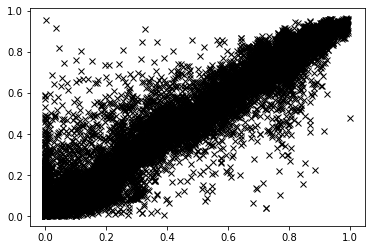

In [605]:
plt.plot(y_train,fits,'kx')



In [517]:
x0=X_val[:1,:]
pred_non_up=[]
for i in range(10):
    pred_non_up.append(best_model.predict(x0))
    

In [518]:
pred_non_up

[array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32),
 array([[0.12278968]], dtype=float32)]

(1, 728)

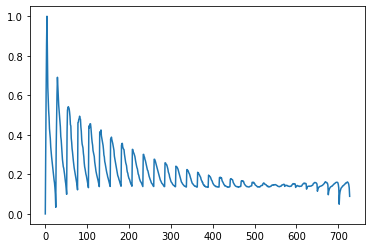